# 02 - Data from the Web

In [2]:
import pandas as pd
import numpy as np
from requests import get
from bs4 import BeautifulSoup as bs
import json
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.import seaborn as sns

## Useful functions

In [231]:
def clean_number(n):
    return int(''.join(filter(lambda c: c.isdigit(), n)))

def select_or_zero(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_number(selection[0].text)

def select_url(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_url(selection[0]['href'])

def normalize_name(name):
    name = str(name)
    name = re.sub('\(.*\)','', name)
    name = re.sub('^The','', name)
    name = re.sub('^É','E', name)
    name = name.replace('–', '-')
    return name.title().strip()

def map_name(name):
    if name == 'Ucl':
        return 'University College London'
    if name == 'Eth Zurich - Swiss Federal Institute Of Technology':
        return 'Eth Zurich - Swiss Federal Institute Of Technology Zurich'
    if name == "King’S College London" or name == "King'S College London":
        return "King's College London"
    if name == 'University Of Freiburg':
        return 'Albert-Ludwigs-Universitaet Freiburg'
    if name == 'Autonomous University Of Barcelona':
        return 'Universitat Autònoma De Barcelona'
    if name == 'Free University Of Berlin':
        return 'Freie Universitaet Berlin'
    if name == 'Heidelberg University':
        return 'Ruprecht-Karls-Universität Heidelberg'
    if name == 'Humboldt University Of Berlin':
        return 'Humboldt-Universität Zu Berlin'
    if name == 'Indiana University':
        return 'Indiana University Bloomington'
    if name == 'Karlsruhe Institute Of Technology':
        return 'Kit, Karlsruhe Institute Of Technology'
    if name == 'Korea Advanced Institute Of Science And Technology':
        return 'Kaist - Korea Advanced Institute Of Science & Technology'
    if name == 'Paris-Sorbonne University - Paris 4':
        return 'Université Paris-Sorbonne (Paris IV)'
    if name == 'Paris-Sud University':
        return 'Université Paris-Sud'
    if name == 'Pierre And Marie Curie University':
        return 'Université Pierre Et Marie Curie'
    if name == 'Radboud University Nijmegen':
        return 'Radboud University'
    if name == 'Royal Holloway, University Of London':
        return 'Royal Holloway University of London'
    if name == 'Rutgers, The State University Of New Jersey':
        return 'Rutgers - The State University of New Jersey, Newark'
    if name == 'Scuola Superiore Sant’Anna':
        return "Scuola Superiore Sant'Anna Pisa Di Studi Universitari E Di Perfezionamento"
    if name == 'Technical University Of Berlin':
        return 'Technische Universität Berlin'
    if name == 'Trinity College Dublin, The University Of Dublin':
        return 'Trinity College Dublin'   
    if name == 'Tu Dresden':
        return 'Technische Universität Dresden'
    if name == 'Ulm University':
        return 'University Ulm'
    if name == 'University Of Bonn':
        return 'Rheinische Friedrich-Wilhelms-Universität Bonn'
    if name == 'University Of Erlangen-Nuremberg':
        return 'Friedrich-Alexander-Universität Erlangen-Nürnberg'
    if name == 'University Of Mannheim':
        return 'Universität Mannheim'
    if name == 'University Of Montreal':
        return 'Université De Montréal'
    if name == 'University Of Münster':
        return 'Westfälische Wilhelms-Universität Münster'
    if name ==  'University Of North Carolina, Chapel Hill':
        return 'University Of North Carolina At Chapel Hill'
    if name == 'University Of Tübingen':
        return 'Eberhard Karls Universität Tübingen'
    if name == 'University Of Würzburg':
        return 'Julius-Maximilians-Universität Würzburg'
    if name == 'Université Libre De Bruxelles':
        return 'Universite libre de Bruxelles'
    if name == 'Wageningen University & Research':
        return 'Wageningen University'
    if name == 'Washington University In St Louis':
        return 'Washington University In St. Louis'
    return name

## Question 1:  TopUniversities website

In [5]:
def get_stats(directory):
    res = get('https://www.topuniversities.com'+directory)
    soup = bs(res.text, "lxml")
    faculty_total = select_or_zero(soup, '.total .text .number')
    faculty_inter = select_or_zero(soup, '.inter .text .number')
    student_total = select_or_zero(soup, '.student .number')
    student_inter = select_or_zero(soup, '.inter .progress-bar-info .number')
    return faculty_total, faculty_inter, student_total, student_inter

def prepare_uni_data_tu(uni):
    uni_infos = dict()
    uni_infos['Name'] = map_name(normalize_name(uni['title']))
    uni_infos['Rank Top Universities'] = clean_number(uni['rank_display'])
    uni_infos['Country'] = uni['country'].strip()
    uni_infos['Region'] = uni['region'].strip()
    uni_infos['Total faculty members'], \
    uni_infos['International faculty members'], \
    uni_infos['Total students'], \
    uni_infos['International students'] = get_stats(uni['url'])
    return uni_infos

res = get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508338164061', 'html')
json_ranking_tu = json.loads(res.text)['data']
json_ranking_tu_top = sorted(json_ranking_tu, key=lambda k: clean_number(k['rank_display']))[:200]
df_tu = pd.DataFrame(list(map(prepare_uni_data_tu,json_ranking_tu_top)))

In [218]:
# df_tu.to_pickle('df_tu.xz')
df_tu = pd.read_pickle('df_tu.xz')

In [232]:
df_tu['Name'] = df_tu['Name'].apply(normalize_name)
df_tu['Name'] = df_tu['Name'].apply(map_name)

In [9]:
def sort(df, column_nominator, column_denominator, column_name):
    df_temp = df.copy()
    df_temp[column_name] = df_temp[column_nominator]/df_temp[column_denominator]
    df_sorted = df_temp.sort_values(by=[column_name], ascending=False)
    return df_sorted

def group(df, grouping_column):
    df_temp = df.copy()
    df_grouped = df_temp.groupby([grouping_column])
    df_aggregated = df_grouped.sum()
    return df_aggregated

def plot(df, x, y, xlabel, ylabel):
    barchart = df.plot.bar(x=x, y=y)
    barchart.set_xlabel(xlabel)
    barchart.set_ylabel(ylabel)
    plt.show()

def reduced_plot(df, x, y, xlabel, ylabel):
    reduced_index = np.arange(10)
    reduced_df = df.take(reduced_index)
    plot(reduced_df, x, y, xlabel, ylabel)

In [10]:
#column index
name = 'Name'
total_faculty_members = 'Total faculty members'
total_students = 'Total students'
international_students = 'International students'
total_students = 'Total students'
faculty_members_students_ratio = 'Ratio faculty members/students'
international_students_ratio = 'Ratio international students'
country = 'Country'
region = 'Region'
students_staff_ratio ='Student/Staff Ratio'
pc_international_students = '% of International Students'
number_international_students = 'Number of International Students'
number_students = 'Number of Students'
#x- and y- labels
university_name = 'University name'

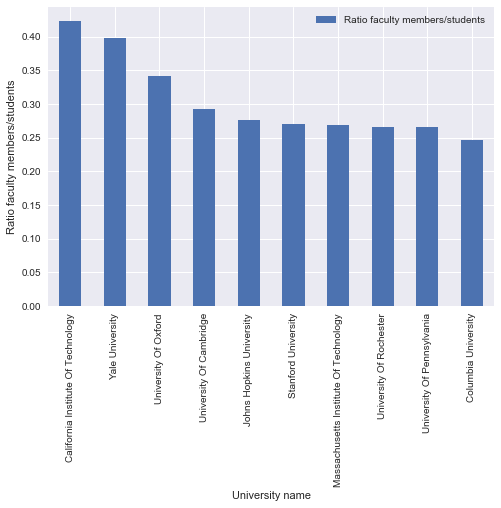

In [11]:
df_tu_QA = sort(df_tu, total_faculty_members, total_students, faculty_members_students_ratio)
reduced_plot(df_tu_QA, name, faculty_members_students_ratio, university_name, faculty_members_students_ratio)

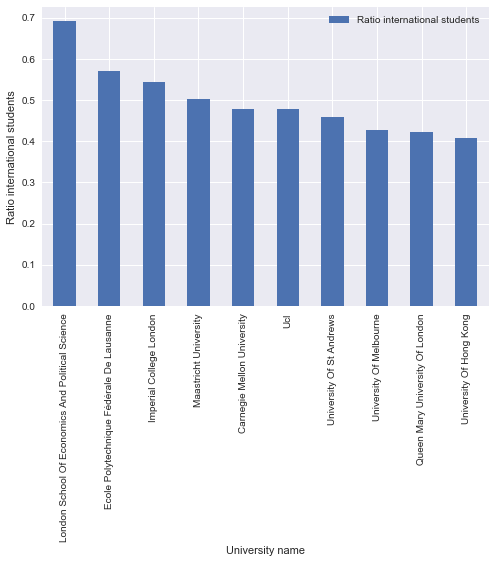

In [12]:
df_tu_QB = sort(df_tu, international_students, total_students, international_students_ratio)
reduced_plot(df_tu_QB, name, international_students_ratio, university_name, international_students_ratio)

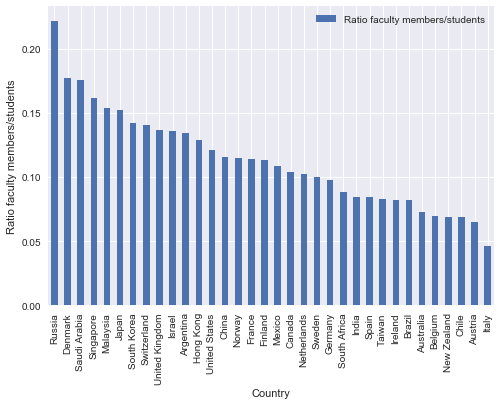

In [13]:
df_tu_country = group(df_tu, country)
df_tu_QAC = sort(df_tu_country, total_faculty_members, total_students, faculty_members_students_ratio).reset_index()
plot(df_tu_QAC, country, faculty_members_students_ratio, country, faculty_members_students_ratio)

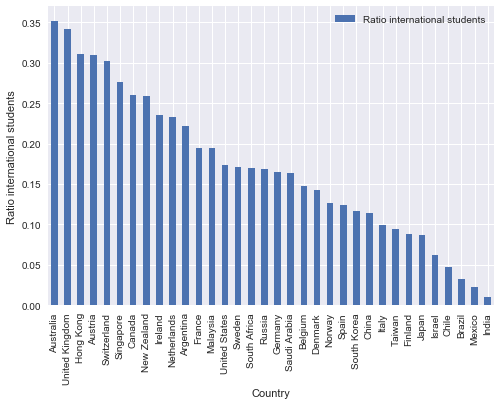

In [14]:
df_tu_QBC = sort(df_tu_country, international_students, total_students, international_students_ratio).reset_index()
plot(df_tu_QBC, country, international_students_ratio, country, international_students_ratio)

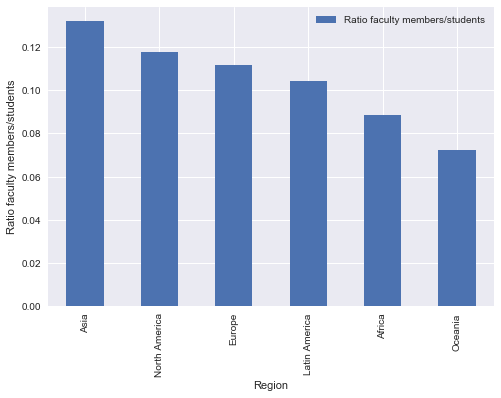

In [15]:
df_tu_region = group(df_tu, region)
df_tu_QAD = sort(df_tu_region, total_faculty_members, total_students, faculty_members_students_ratio).reset_index()
plot(df_tu_QAD, region, faculty_members_students_ratio, region, faculty_members_students_ratio)

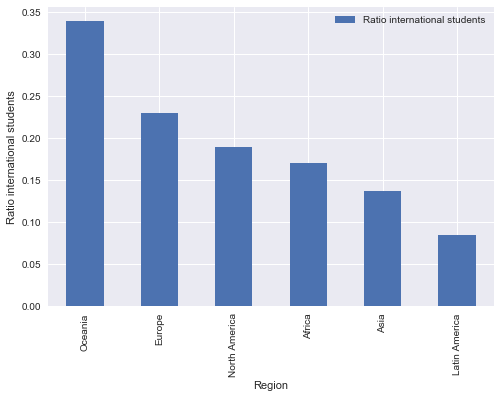

In [16]:
df_tu_QBD = sort(df_tu_region, international_students, total_students, international_students_ratio).reset_index()
plot(df_tu_QBD, region, international_students_ratio, region, international_students_ratio)

## Question 2: Times Higher Education webpage

In [233]:
def prepare_uni_data_the(uni):
    uni_infos = dict()
    uni_infos['Name'] = map_name(normalize_name(uni['name']))
    uni_infos['Country'] = uni['location']
    uni_infos['Rank Time Higher Education'] = clean_number(uni['rank'])
    uni_infos['Number of Students'] = clean_number(uni['stats_number_students'])
    uni_infos['Student/Staff Ratio'] = clean_number(uni['stats_student_staff_ratio'])
    uni_infos['% of International Students'] = clean_number(uni['stats_pc_intl_students'])
    return uni_infos
res = get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json', 'html')
json_ranking_the = json.loads(res.text)['data']
json_ranking_the = sorted(json_ranking_the, key=lambda k: clean_number(k['rank']))[:200]
df_the = pd.DataFrame(list(map(prepare_uni_data_the,json_ranking_the)))
# # get_missing_uni(df)

In [20]:
# df_the.to_pickle('df_the.xz')
df_the = pd.read_pickle('df_the.xz')
# df = df_tu.merge(df_the, 'outer', on='Name')
# df = get_missing_uni(df).set_index('Name').combine_first(df.set_index('Name'))

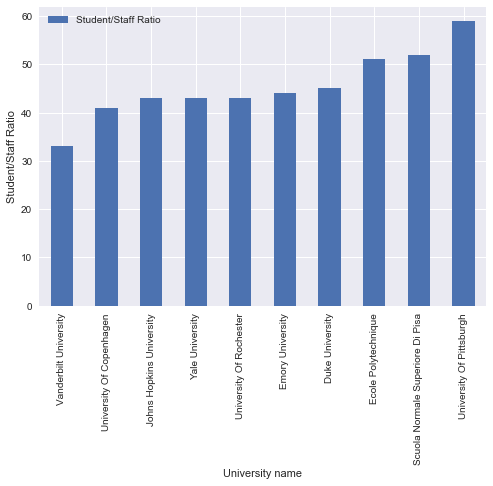

In [18]:
#NOTE! student/staff ratio value are multiplied x10, no difference in sorting
#NOTE! ascending order in student/staff ratio == descending order in staff/student ratio
# and we're looking for staff/student ratio (assuming staff == faculty members)
df_the_QA = df_the.sort_values([students_staff_ratio], ascending=True)
reduced_plot(df_the_QA, name, students_staff_ratio, university_name, students_staff_ratio)

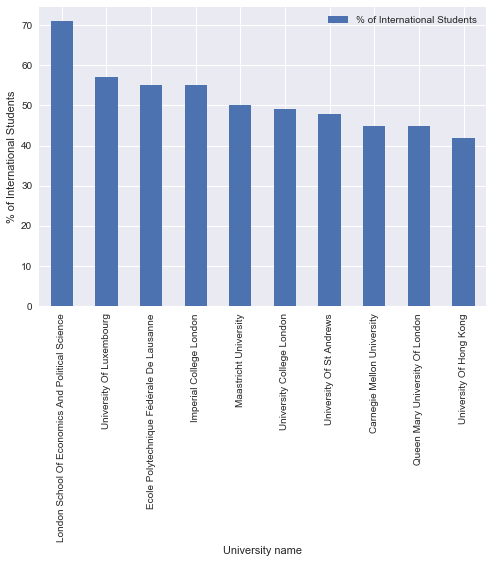

In [19]:
df_the_QB = df_the.sort_values([pc_international_students], ascending=False)
reduced_plot(df_the_QB, name, pc_international_students, university_name, pc_international_students)

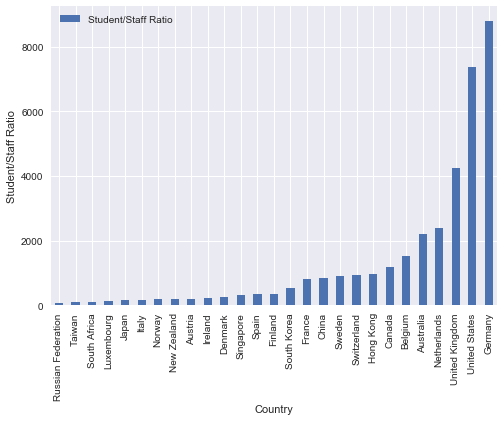

In [20]:
df_the_country = group(df_the, country)
df_the_QAC = df_the_country.sort_values([students_staff_ratio], ascending=True).reset_index()
plot(df_the_QAC, country, students_staff_ratio, country, students_staff_ratio)

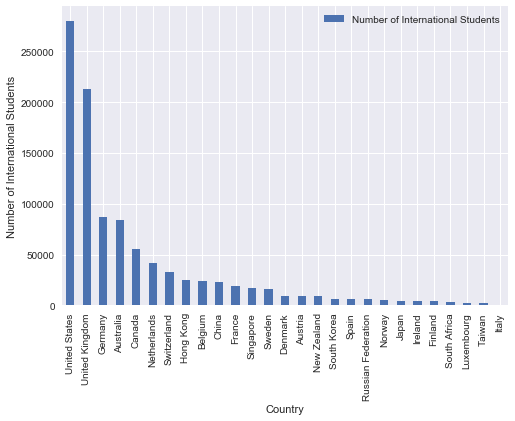

In [21]:
#NOTE i don't use math.ceil() on number of international students because i couldn't implement swiftly.
#less chanches of ties anyway
df_temp = df_the
df_temp[number_international_students] = df_temp[pc_international_students]*df_temp[number_students]/100
df_the_QBC = group(df_temp, country)
df_the_QBC = df_the_QBC.sort_values([number_international_students], ascending=False).reset_index()
plot(df_the_QBC, country, number_international_students, country, number_international_students)

In [22]:
def countryRegionMapping(df_to_map):
    df_with_mapping = df_tu[[country, region]].drop_duplicates()
    df_mapped = df_to_map.merge(df_with_mapping)
    return df_mapped

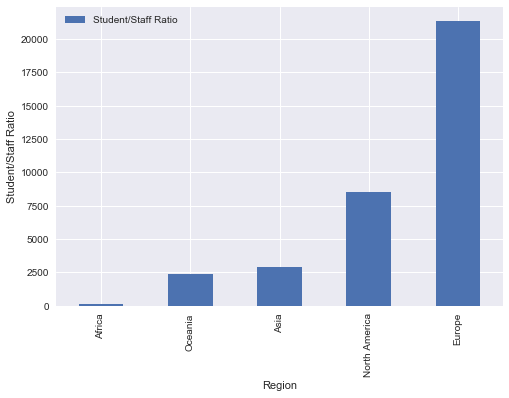

In [23]:
df_mapped = countryRegionMapping(df_the)
df_the_region = group(df_mapped, region)
df_the_QAD = df_the_region.sort_values([students_staff_ratio], ascending=True).reset_index()
plot(df_the_QAD, region, students_staff_ratio, region, students_staff_ratio)

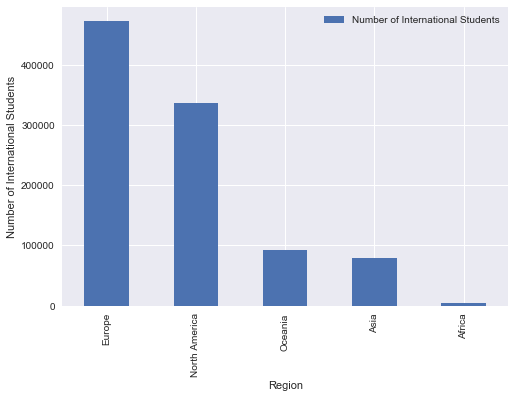

In [24]:
df_mapped = countryRegionMapping(df_temp)
df_the_QBD = group(df_mapped, region)
df_the_QBD = df_the_QBD.sort_values([number_international_students], ascending=False).reset_index()
plot(df_the_QBD, region, number_international_students, region, number_international_students)

# Question 3: dataframes merging

In [241]:
def complete_with_tu(name):
    for uni in json_ranking_tu:
        if normalize_name(uni['title']) == name:
            return prepare_uni_data_tu(uni)
        
def complete_with_the(name):
    for uni in json_ranking_the:
        if normalize_name(uni['name']) == name:
            return prepare_uni_data_the(uni)

def get_missing_uni(df):
    completion = []
    for missing in df[df['Rank Top Universities'].isnull()]['Name']:
        tu_data = complete_with_tu(missing)
        if tu_data:
            completion.append(tu_data)
    for missing in df[df['Rank Time Higher Education'].isnull()]['Name']:
        the_data = complete_with_the(missing)
        if the_data:
            completion.append(the_data)
    return pd.DataFrame(completion)

merged_df = df_tu.merge(df_the, 'outer', on=['Name'])

# filtered_merged_df = merged_df[merged_df['Country_x'].notnull() & merged_df['Country_y'].notnull()]
# filtered_merged_df
# merged_df = merged_df.merge(get_missing_uni(merged_df), 'left', on=['Name'])
# df[df['Country'].isnull()]
# df[df['Name'].str.contains('Gothenburg')]

In [242]:
missing = get_missing_uni(merged_df)
missing.drop('Country', axis=1, inplace=True)

In [243]:
merged_df = missing.set_index('Name').combine_first(merged_df.set_index('Name')).reset_index()
merged_df

,Name,% of International Students,Country_x,Country_y,International faculty members,International students,Number of Students,Rank Time Higher Education,Rank Top Universities,Region,Student/Staff Ratio,Total faculty members,Total students
0,Aalto University,20.0,Finland,Finland,370.0,1831.0,12744.0,190.0,137.0,Europe,202.0,1257.0,12147.0
1,Aarhus University,12.0,Denmark,Denmark,602.0,3762.0,25167.0,109.0,119.0,Europe,143.0,2316.0,26226.0
2,Albert-Ludwigs-Universitaet Freiburg,19.0,Germany,Germany,413.0,3897.0,20871.0,82.0,171.0,Europe,403.0,1966.0,23214.0
3,Alma Mater Studiorum - University Of Bologna,NaN,Italy,NaN,153.0,4195.0,NaN,NaN,188.0,Europe,NaN,2990.0,63399.0
4,Arizona State University,19.0,NaN,United States,588.0,9722.0,44475.0,126.0,209.0,North America,201.0,2578.0,47503.0
5,Australian National University,35.0,Australia,Australia,927.0,5551.0,15986.0,48.0,20.0,Oceania,193.0,1600.0,14442.0
6,Boston University,25.0,United States,United States,379.0,7041.0,24833.0,70.0,81.0,North America,86.0,3157.0,25662.0
7,Brown University,20.0,United States,United States,379.0,1825.0,8898.0,50.0,53.0,North America,107.0,1303.0,9251.0
8,California Institute Of Technology,27.0,United States,United States,350.0,647.0,2209.0,3.0,4.0,North America,65.0,953.0,2255.0
9,Cardiff University,26.0,United Kingdom,United Kingdom,705.0,6090.0,24186.0,162.0,137.0,Europe,135.0,2755.0,24565.0


In [249]:
null_df = merged_df[merged_df['Rank Time Higher Education'].isnull() | merged_df['Rank Top Universities'].isnull()]
null_df = merged_df[merged_df['Rank Time Higher Education'].isnull()]
null_df

,Name,% of International Students,Country_x,Country_y,International faculty members,International students,Number of Students,Rank Time Higher Education,Rank Top Universities,Region,Student/Staff Ratio,Total faculty members,Total students
3,Alma Mater Studiorum - University Of Bologna,NaN,Italy,NaN,153.0,4195.0,NaN,NaN,188.0,Europe,NaN,2990.0,63399.0
12,Centralesupélec,NaN,France,NaN,137.0,1132.0,NaN,NaN,177.0,Europe,NaN,529.0,3877.0
13,Chalmers University Of Technology,NaN,Sweden,NaN,336.0,1465.0,NaN,NaN,133.0,Europe,NaN,1077.0,9257.0
25,"Ecole Normale Supérieure, Paris",NaN,France,NaN,75.0,374.0,NaN,NaN,43.0,Europe,NaN,178.0,1907.0
38,Hanyang University,NaN,South Korea,NaN,364.0,3397.0,NaN,NaN,155.0,Asia,NaN,3085.0,23348.0
40,Hebrew University Of Jerusalem,NaN,Israel,NaN,454.0,1034.0,NaN,NaN,145.0,Asia,NaN,2249.0,16531.0
41,Hokkaido University,NaN,Japan,NaN,210.0,1347.0,NaN,NaN,122.0,Asia,NaN,2605.0,17552.0
46,Indian Institute Of Science Bangalore,NaN,India,NaN,NaN,47.0,NaN,NaN,190.0,Asia,NaN,423.0,4071.0
47,Indian Institute Of Technology Bombay,NaN,India,NaN,19.0,93.0,NaN,NaN,179.0,Asia,NaN,876.0,9402.0
48,Indian Institute Of Technology Delhi,NaN,India,NaN,4.0,80.0,NaN,NaN,172.0,Asia,NaN,466.0,7477.0


In [230]:
merged_df[merged_df['Name'].str.contains('Eth')]['Name'].values

# Question 4: Exploratory analysis

In [88]:
def factorize(df, variable):
    labels, uniques = pd.factorize(df[variable])
    df[variable] = labels
def compute_correlation(x_variable, y_variable, x_needs_factorization = False, y_needs_factorization = False):
    correlation_df = filtered_merged_df[[x_variable, y_variable]]
    if x_needs_factorization:
        factorize(correlation_df, x_variable)
    if y_needs_factorization:
        factorize(correlation_df, y_variable)
    return correlation_df.corr()

In [94]:
countryx = 'Country_x'
international_faculty_members = 'International faculty members'
rank_tu = 'Rank Top Universities'
rank_the = 'Rank Time Higher Education'

In [104]:
#correlation country-number of international students
country_istudents_correlation_tu = compute_correlation(countryx, international_students, x_needs_factorization = True)
country_istudents_correlation_the = compute_correlation(countryx, number_international_students, x_needs_factorization = True)

#correlation number of international faculty members - number of international students
imembers_istudents_correlation_tu = compute_correlation(international_faculty_members, international_students)

#correlation country-ranking
country_ranking_correlation_tu = compute_correlation(countryx, rank_tu, x_needs_factorization = True)
country_ranking_correlation_the = compute_correlation(countryx, rank_the, x_needs_factorization = True)

#correlation region-ranking
country_ranking_correlation_tu = compute_correlation(region, rank_tu, x_needs_factorization = True)
country_ranking_correlation_the = compute_correlation(region, rank_the, x_needs_factorization = True)

#correlation total faculty members - total students
country_ranking_correlation_tu = compute_correlation(total_faculty_members, total_students)

,Total faculty members,Total students
Total faculty members,1.000000,0.594918
Total students,0.594918,1.000000


In [107]:
#correlation country-number of international students for tu
compute_correlation(countryx, international_students, x_needs_factorization = True)
#low correlation

,Country_x,International students
Country_x,1.000000,-0.122402
International students,-0.122402,1.000000


In [106]:
#correlation country-number of international students for the
compute_correlation(countryx, number_international_students, x_needs_factorization = True)
#low correlation

,Country_x,Number of International Students
Country_x,1.000000,-0.188025
Number of International Students,-0.188025,1.000000


In [108]:
#correlation number of international faculty members - number of international students for tu
compute_correlation(international_faculty_members, international_students)
#semi-linear relationship (makes sense)

,International faculty members,International students
International faculty members,1.000000,0.546366
International students,0.546366,1.000000


In [109]:
#correlation country-ranking for tu
compute_correlation(countryx, rank_tu, x_needs_factorization = True)
#low correlation

,Country_x,Rank Top Universities
Country_x,1.000000,0.282297
Rank Top Universities,0.282297,1.000000


In [118]:
#correlation country-ranking for the
compute_correlation(countryx, rank_the, x_needs_factorization = True)
#kinda normal correlation

,Country_x,Rank Time Higher Education
Country_x,1.000000,0.442349
Rank Time Higher Education,0.442349,1.000000


In [116]:
#correlation region-ranking for tu
compute_correlation(region, rank_tu, x_needs_factorization = True)

,Region,Rank Top Universities
Region,1.000000,-0.054888
Rank Top Universities,-0.054888,1.000000


In [110]:
#correlation region-ranking for the
compute_correlation(region, rank_the, x_needs_factorization = True)
#kinda low correlation

,Region,Rank Time Higher Education
Region,1.000000,0.330236
Rank Time Higher Education,0.330236,1.000000


In [112]:
#correlation total faculty members - total students for tu
compute_correlation(total_faculty_members, total_students)
#kinda high correlation - makes sense

,Total faculty members,Total students
Total faculty members,1.000000,0.594918
Total students,0.594918,1.000000


In [113]:
#correlation rank in first website - rank in second website
compute_correlation(rank_tu, rank_the)
# very high correlation thanks god - makes sense

,Rank Top Universities,Rank Time Higher Education
Rank Top Universities,1.000000,0.697195
Rank Time Higher Education,0.697195,1.000000


# Question 5: best university

simply take the average of the two ranking associated to each university

In [126]:
mean_rank = 'mean rank'

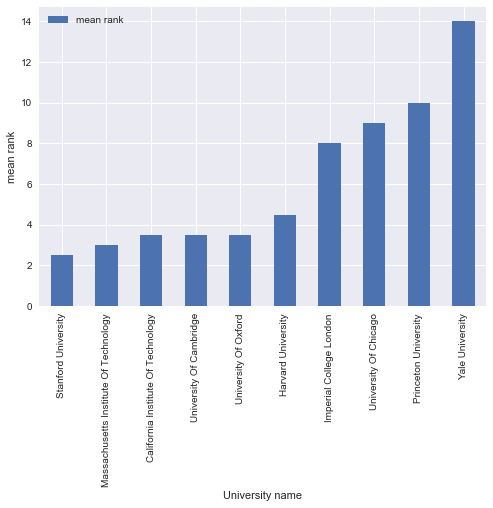

In [128]:
filtered_merged_df[mean_rank] = (filtered_merged_df[rank_tu]+filtered_merged_df[rank_the])/2
mean_ranking_df = filtered_merged_df.sort_values(by=[mean_rank], ascending=True)
reduced_plot(mean_ranking_df, name, mean_rank, university_name, mean_rank)